# Pleiades: Workprecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Pleiades">
             Initial value problem: Pleiades</a></li>     
                          
<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             

</ul>  

- PLEI- a celestial mechanics problem: seven stars in the plane with coordinates $x_i,y_i$ and masses $m_i=i$ ($i=1,\dots,7$)  

\begin{align*}
&x_i^{''}=\sum_{j \ne i} m_j(x_j-x_i)/r_{ij} \\
&y_i^{''}=\sum_{j \ne i} m_j(y_j-y_i)/r_{ij} 
\end{align*}

where

\begin{align*}
r_{ij}=((x_i-x_j)^2+ (y_i-y_j)^2)^{3/2}, \quad i,j=1,\dots,7
\end{align*}

- The initial values are

\begin{align*}
& x_1(0)=3, \quad x_2(0)=3, \quad x_3(0)=-1, \quad x_4(0)=-3, \\
& x_5(0)=2, \quad x_6(0)=-2, \quad x_7(0)=2 \\
& y_1(0)=3, \quad y_2(0)=-3, \quad y_3(0)=2, \quad y_4(0)=0, \\
& y_5(0)=0, \quad y_6(0)=-4, \quad y_7(0)=4, \\
& x'_i(0)=y'_i(0)=0 \ \text{ for all } i \text{ with the exception of} \\
& x'_6(0)=1.75, \quad x'_7(0)=-1.5, \quad y'_4(0)=-1.25, \quad y'_5(0)=1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Solving Ordinary Differential Equations I (Nonstiff Problems), E.Hairer, S.P:Norsett, G.Wanner, (245 page), Springer

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Pleiades

In [4]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/NbodyDyn.jl")
include("../ODEProblems/Nbody2nd.jl")
include("../ODEProblems/InitialPleiades.jl")

t0=0.0
t1=3.0

u064, Gm64 =InitialPleiades(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64, Gm64);

u0128, Gm128=InitialPleiades(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128, Gm128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

q064=copy(u064[:,:,1])
v064=copy(u064[:,:,2])
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64, Gm64)
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64, Gm64)


q0128=copy(u0128[:,:,1])
v0128=copy(u0128[:,:,2])
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128, Gm128)
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128, Gm128);

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/plei_test_sol.jld2" sol

@load "./Data/plei_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256, Gm256 =InitialPleiades(BigFloat)

E0=NbodyEnergy(u0256,Gm256)
(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0.-1))

(3.0f0, 4.0151787f-33)

In [6]:
ux=sol.u[end]
#test_sol=Float64.(TestSolution(tspan128,[ux]))
soldyn=ArrayPartition(ux[:,:,1], ux[:,:,2])
test_soldyn = TestSolution(t1,[soldyn])
#
solx2nd=ArrayPartition( ux[:,:,2],ux[:,:,1])
test_solx2nd = TestSolution(t1,[solx2nd]);
#
test_SOL= TestSolution(t1,[sol.u[end]]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [7]:
abstols = 1.0 ./ 10.0 .^ (10:15)
reltols = 1.0 ./ 10.0 .^ (10:15);

### Second Order Problem: Vern9, IRKGL16, DPRKN12

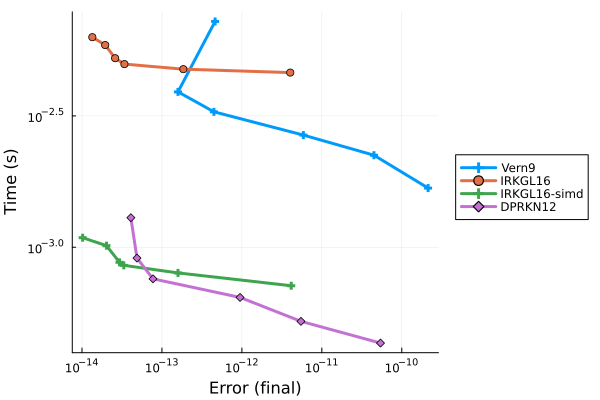

In [8]:
setups = [
          Dict(:alg=>Vern9())
]
solnames = ["Vern9"]
wp1 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_soldyn, save_everystep=false,numruns=100,maxiters=10^9, names=solnames);
plot(wp1);

#########################################################

setups = [
          Dict(:alg=>IRKGL16(second_order_ode=true,simd=false),:adaptive=>true)
          Dict(:alg=>IRKGL16(second_order_ode=true,simd=true),:adaptive=>true)
]
solnames = ["IRKGL16", "IRKGL16-simd"]
wp2 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_SOL,save_everystep=false,numruns=100,maxiters=10^9, names=solnames);
plot!(wp2);

#########################################################

setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=100,maxiters=10^9,name=solnames)
plot!(wp3)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [9]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Second Order ODE: Vern9, IRKGL16, 

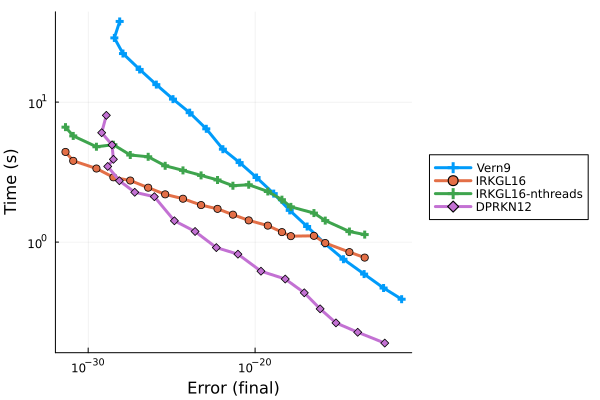

In [10]:
setups = [
          Dict(:alg=>Vern9())
]
solnames = ["Vern9"]
wp11 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_soldyn, save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot(wp11);

#########################################################

setups = [
          Dict(:alg=>IRKGL16(second_order_ode=true),:adaptive=>true)
          Dict(:alg=>IRKGL16(second_order_ode=true,threading=true),:adaptive=>true) 
]
solnames = ["IRKGL16", "IRKGL16-nthreads"]
wp12 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_SOL,save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot!(wp12);

#########################################################

setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,name=solnames)
plot!(wp13)

<a href="#top">Back to the top</a>